In [1]:
import gurobipy
import pandas as pd
from IORFA import *
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from pauls_functions_advanced import *

18d872627be647b0178f56f4ee2d1bfee29192a168717377dc73402f8855d847


In [2]:
depth = 2

In [3]:
def find_rules_from_node_x(x, odt):

    # Find the active splits (those that are actually used) at the first node
    active_splits_at_node_x =  {i: odt.a[i] for i in list(odt.a.keys()) if (i[1] == x and odt.a[i].X == 1)}

    # Store the splitting variable and the threshold together
    for key in list(active_splits_at_node_x.keys()):
        active_splits_at_node_x[(key[0], odt.b[x].X)] = active_splits_at_node_x[key]
        del active_splits_at_node_x[key]

    # Make rules out of them
    rules_from_node_x = {(f"X[:, {key[0]}] <= " + str(key[1]), 
                        f"X[:, {key[0]}] > " + str(key[1]) )           
                        for key in active_splits_at_node_x.keys()}
    
    return rules_from_node_x

def chain_rules(odt):
    
    rules_N1 = list(find_rules_from_node_x(1, odt))[0]
    rules_N2 = list(find_rules_from_node_x(2, odt))[0]
    rules_N3 = list(find_rules_from_node_x(3, odt))[0]

    path1 = "(" + rules_N1[0] + ")" + " * " + "(" + (rules_N2[0]) + ")"
    path2 = "(" +(rules_N1[0])+ ")" + " * " + "(" + (rules_N2[1]) + ")"
    path3 = "(" +(rules_N1[1]) + ")" + " * " +  "(" +(rules_N3[0]) + ")"
    path4 = "(" +(rules_N1[1]) + ")" + " * " + "(" +(rules_N3[1]) + ")"


    return [path1, path2, path3, path4]


def add_rules_to_df(rules, X):

    X = np.matrix(X)

    for rule in rules:
        rule_ind = [1 if i in np.where(eval(rule))[0] else 0 for i in range(X.shape[0]) ]
        X = pd.DataFrame(X)
        X[rule] = rule_ind
    
    return X

def IORFA(X, odt):
    rules = chain_rules(odt)
    betas = [odt.beta[i].X for i in list(odt.beta.keys())]
    gammas = [odt.gamma[i].X for i in list(odt.gamma.keys())]
    coefficients = betas + gammas
    rule_df = np.matrix(add_rules_to_df(rules, X))
    preds = []
    for i in range(X.shape[0]):
        y_i = sum(rule_df[i, j]*coefficients[j] for j in range(len(coefficients)))
        preds.append(y_i)
    
    return preds

In [4]:
from sklearn.datasets import load_diabetes

In [5]:
data = load_diabetes()

In [6]:
X = pd.DataFrame(data['data'])

In [7]:
X

,0,1,2,3,4,5,6,7,8,9
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019907,-0.017646
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068332,-0.092204
2,0.085299,0.050680,0.044451,-0.005670,-0.045599,-0.034194,-0.032356,-0.002592,0.002861,-0.025930
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022688,-0.009362
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031988,-0.046641
...,...,...,...,...,...,...,...,...,...,...
437,0.041708,0.050680,0.019662,0.059744,-0.005697,-0.002566,-0.028674,-0.002592,0.031193,0.007207
438,-0.005515,0.050680,-0.015906,-0.067642,0.049341,0.079165,-0.028674,0.034309,-0.018114,0.044485
439,0.041708,0.050680,-0.015906,0.017293,-0.037344,-0.013840,-0.024993,-0.011080,-0.046883,0.015491
440,-0.045472,-0.044642,0.039062,0.001215,0.016318,0.015283,-0.028674,0.026560,0.044529,-0.025930


In [8]:
y = pd.DataFrame(data['target'])

In [9]:
y

,0
0,151.0
1,75.0
2,141.0
3,206.0
4,135.0
...,...
437,178.0
438,104.0
439,132.0
440,220.0


In [10]:
X = np.array(X)
X = (X - np.min(X)) / (np.max(X) - np.min(X))
y = np.array(y)

In [11]:
y = y.flatten()

In [12]:
odt = optimalDecisionTreeClassifier(max_depth=depth,warmstart=True,output=True)
odt.fit(X, y)
preds = IORFA(X, odt)

Training data include 442 instances, 10 features.
Set parameter Username
Academic license - for non-commercial use only - expires 2023-11-30
Set parameter TimeLimit to value 600
Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (mac64[x86])

CPU model: Intel(R) Core(TM) i7-9750H CPU @ 2.60GHz
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 5762 rows, 3566 columns and 53087 nonzeros
Model fingerprint: 0x42602353
Model has 1 quadratic constraint
Variable types: 1761 continuous, 1805 integer (1805 binary)
Coefficient statistics:
  Matrix range     [1e-02, 2e+00]
  QMatrix range    [1e+00, 1e+00]
  QLMatrix range   [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]

User MIP start produced solution with objective 0 (0.16s)
Loaded user MIP start with objective 0


Explored 0 nodes (0 simplex iterations) in 0.16 seconds (0.13 work units)
Thread count was 1 (of 12 available pr

In [13]:
LinearRegression().fit(X, y).score(X, y)

0.5177484222203498

In [14]:
r2_score(y, preds)

-3.9030432134696262

In [15]:
iters = 1
names = ['Reg-CART','CART','ORT','OCT','ORT-H','OCT-H']

r2s = {i: {} for i in range(iters)}

np.random.seed(22)

for iter in range(iters):

    # X = np.random.normal(size = (1000, 10))

    # X = (X - np.min(X)) / (np.max(X) - np.min(X))

    # x1 = X[:, 0]
    # x2 = X[:, 1]

    # y = 0 + 1*(x1 < 0.3)*(x2 >-0.3)

    # display(type(X))

    # display(type(y))

    # odt = optimalDecisionTreeClassifier(max_depth=depth,warmstart=False,output=True)
    # odt.fit(X, y)
    # preds = IORFA(X, odt)

    # raise Exception

    # r2s[iter]['IORFA'] = r2_score(preds, y)

    X = pd.DataFrame(X)


    models, performance = generate_tree(X, y, X, y, 
                                        n_num=2, feat_size=2,  max_iter_hy=2, 
                                        depth_bi=2, depth_hy=2, complexity_bi=0.001, 
                                        complexity_hy=0.001, depth_grid_bi=False, depth_grid_hy=False, 
                                        Reg_CART=True, ORT=True, ORT_H=False, 
                                        Clas_CART=False, OCT=False, OCT_H=False)

    act_name = []
    act_rules = []
    for model,name in zip(models,names):
        if not not model:
            act_name += [name]
            act_rules += [model]
    
    X.rename(columns = {0: "0", 1: "1"}, inplace = True)

    datasets = gen_train_and_test_features(act_rules, act_name, X, X)

    log_reg_acc = linear_regression_pipeline(X, X, y, y)

    r2s[iter]["Linear Regression"] = log_reg_acc
    r2s[iter]["Reg CART"] = performance['Reg CART'].iloc[0]
    r2s[iter]["ORT"] = performance['ORT'].iloc[0]

    for model in datasets.keys():

        X_train_rules_and_features, X_test_rules_and_features = datasets[model][0]
        X_train_only_rules, X_test_only_rules = datasets[model][1]

        only_rules_acc = linear_regression_pipeline(X_train_only_rules, X_test_only_rules, y, y)

        rules_and_features_acc = linear_regression_pipeline(X_train_rules_and_features, X_test_rules_and_features, y, y)

        r2s[iter][model + "_rules_and_features"] = rules_and_features_acc


In [ ]:
r2s

{0: {'IORFA': 1.0}}

In [ ]:
# IORFA_res = pd.DataFrame(IORFA_list, columns = ['IORFA'])
# linreg_res = pd.DataFrame(linreg_list, columns = ['Lin. Regression'])
# ORT_res = pd.DataFrame(ORT_list, columns = ['ORT'])

In [ ]:
r2s

{0: {'IORFA': 1.0}}

In [ ]:
results = pd.DataFrame(r2s)

In [ ]:
results

,0
IORFA,1.0


In [ ]:
results = results.T

In [ ]:
benchmark_cols = list(results.columns[1:])

benchmark_cols.append("IORFA")

results = results[benchmark_cols]

In [ ]:
results.rename(columns = {"Reg-CART_rules_and_features": "RuleFit", "ORT_rules_and_features": "ORFA", "Linear Regression": "Lin. Regression"}, inplace = True)

In [ ]:
results.iloc[:25]

,IORFA
0,1.0


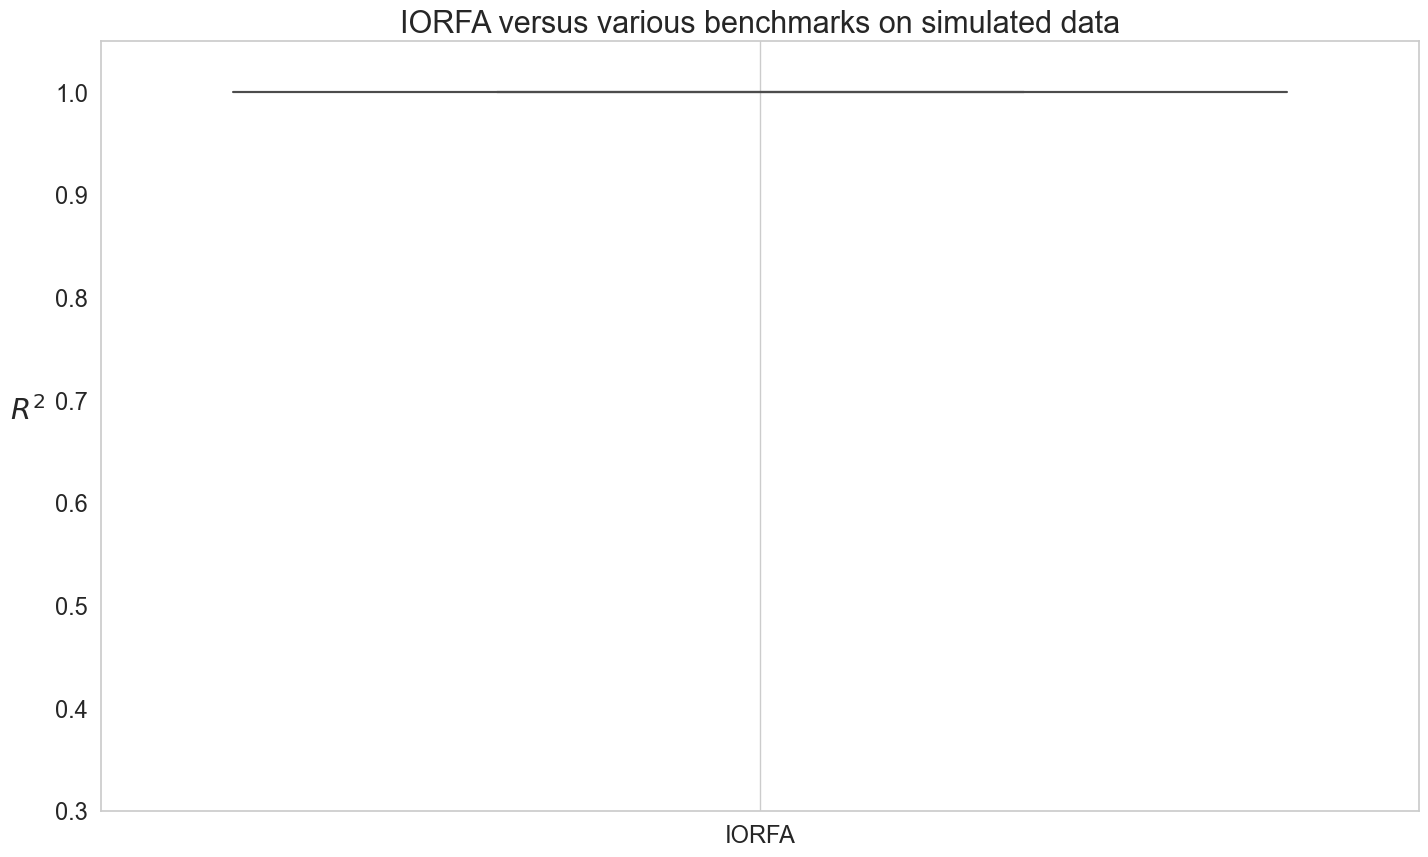

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
fig, ax= plt.subplots()


fig.set_size_inches(17, 10)
sns.boxplot(data = results.iloc[:25], ax= ax)
ax.set_ylim(0, 1.1)


sns.set(rc={'axes.facecolor':'white', 'figure.facecolor':'white'})
sns.set_style("whitegrid")
ax.yaxis.grid(False) # Hide the horizontal gridlines
ax.xaxis.grid(True) # Show the vertical gridlines

ax.set_title("IORFA versus various benchmarks on simulated data", fontsize = 22)
ax.set_ylabel(r"$R^2$", rotation = 0, fontsize = 21, labelpad = 20)
ax.set_ylim(0.3, 1.05)


ax.tick_params(rotation =0, labelsize = 17)

In [ ]:
results.mean()

IORFA    1.0
dtype: float64